# NumPyro Integration with Other Libraries

In this notebook we describe how to integrate NumPyro with other libraries to take advantage of alternative inference algorithms. We focus on two libraries:

- [Blackjax](https://blackjax-devs.github.io/blackjax/)
  - We consider the [Pathfinder](https://blackjax-devs.github.io/blackjax/autoapi/blackjax/vi/pathfinder/index.html) variational inference algorithm.
- [FlowMC](https://flowmc.readthedocs.io/en/main/)
  - We look into the normalizing-flow enhanced Markov chain Monte Carlo.

The main idea behind the integration is to use the function `numpyro.infer.util.initialize_model` to compute the log-density and the necessary transformations to go from the unconstrained space to the constrained space. Let's see how to do it.

This example is based on the original example notebook [NumPyro with Pathfinder](https://juanitorduz.github.io/numpyro_pathfinder/).

## Prepare Notebook

In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro arviz blackjax flowMC

In [2]:
import arviz as az
import blackjax
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
from flowMC.proposal.MALA import MALA
from flowMC.Sampler import Sampler
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer.util import Predictive, initialize_model

plt.style.use("bmh")

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Synthetic Data

We generate some data from a simple linear regression model.

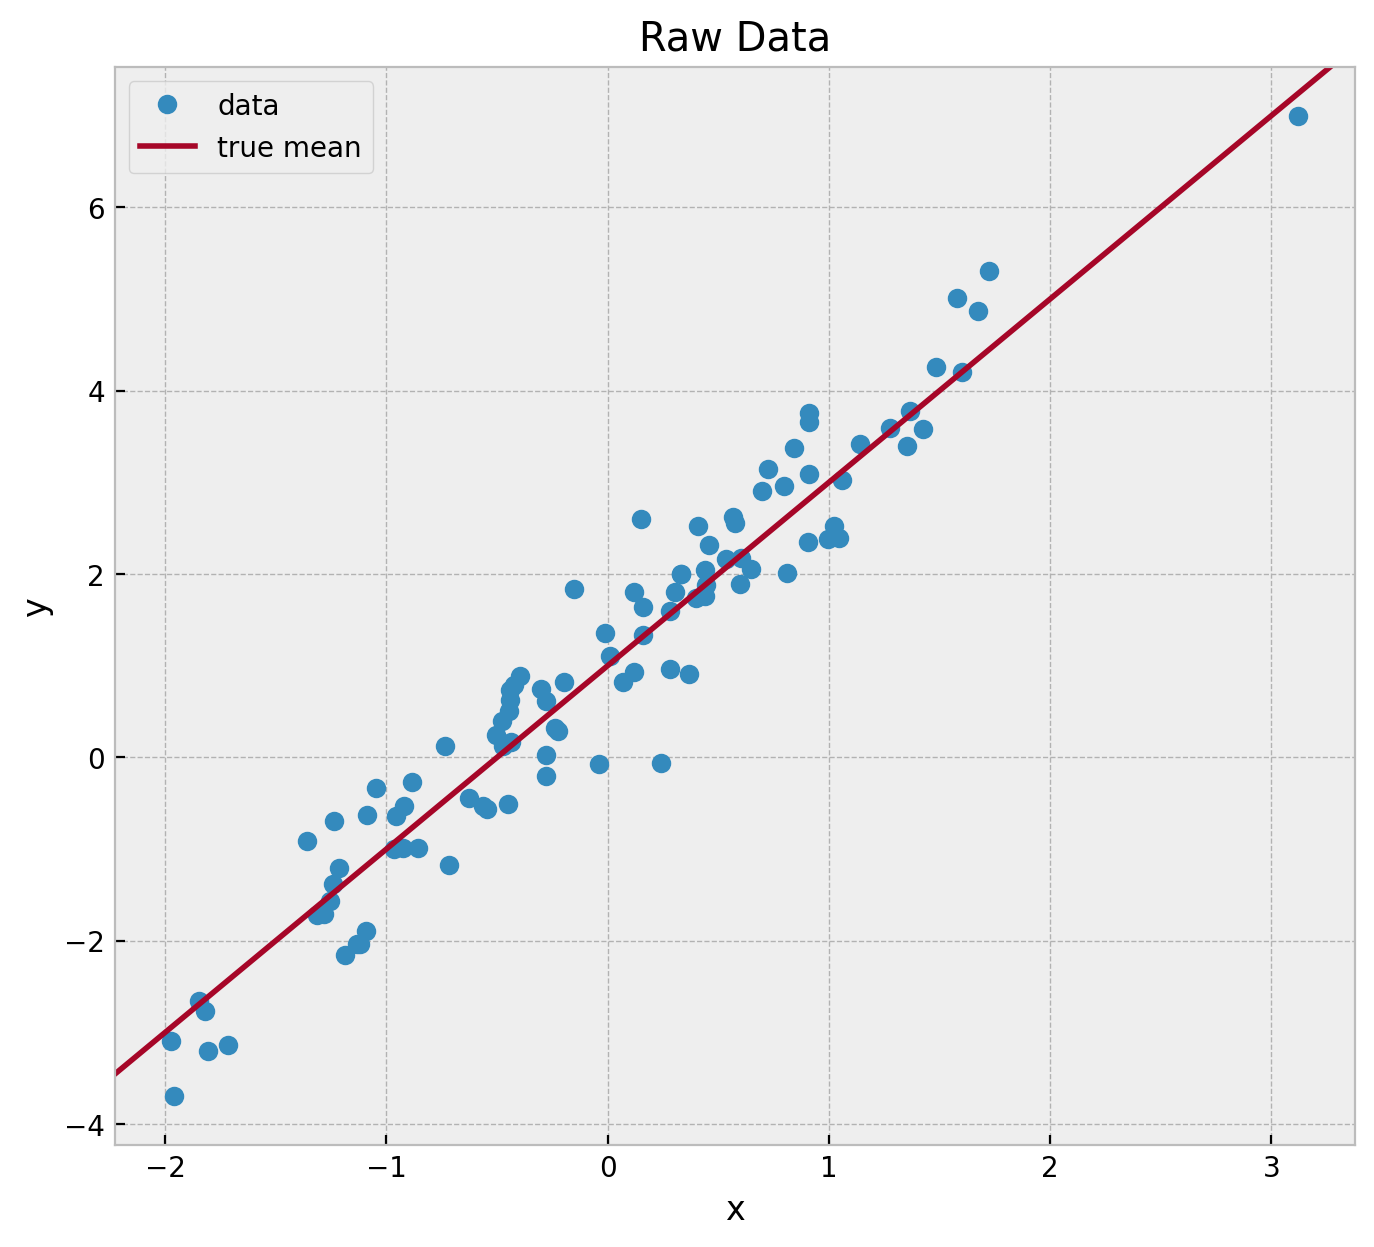

In [3]:
def generate_data(rng_key, a, b, sigma, n):
    x = random.normal(rng_key, (n,))
    rng_key, rng_subkey = random.split(rng_key)
    epsilon = sigma * random.normal(rng_subkey, (n,))
    y = a + b * x + epsilon
    return x, y


# true parameters
a = 1.0
b = 2.0
sigma = 0.5
n = 100

# generate data
rng_key, rng_subkey = random.split(rng_key)
x, y = generate_data(rng_key, a, b, sigma, n)

# plot data
fig, ax = plt.subplots(figsize=(8, 7))
ax.plot(x, y, "o", c="C0", label="data")
ax.axline((0, a), slope=b, color="C1", label="true mean")
ax.legend(loc="upper left")
ax.set(xlabel="x", ylabel="y", title="Raw Data");

## Model Specification

We define a simple linear regression model in NumPyro.

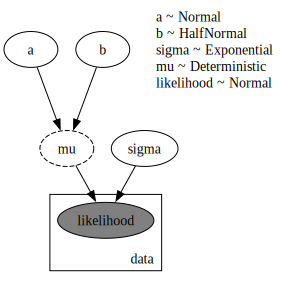

In [4]:
def model(x, y=None):
    a = numpyro.sample("a", dist.Normal(loc=0.0, scale=2.0))
    b = numpyro.sample("b", dist.HalfNormal(scale=2.0))
    sigma = numpyro.sample("sigma", dist.Exponential(rate=1.0))
    mean = numpyro.deterministic("mu", a + b * x)
    with numpyro.plate("data", len(x)):
        numpyro.sample("likelihood", dist.Normal(loc=mean, scale=sigma), obs=y)


numpyro.render_model(
    model=model,
    model_args=(x, y),
    render_distributions=True,
    render_params=True,
)

## Extract Model Ingredients

As mentioned in the introduction, we need to use the function `numpyro.infer.util.initialize_model` to extract the log-density and the necessary transformations to go from the unconstrained space to the constrained space needed by Blackjax and FlowMC. The input to this function is the model, the data, and a random key.

In [5]:
rng_key, rng_subkey = random.split(rng_key)
param_info, potential_fn, postprocess_fn, *_ = initialize_model(
    rng_subkey,
    model,
    model_args=(x, y),
    dynamic_args=True,  # <- this is important!
)

- `param_info` is a namedtuple `ParamInfo` containing values from the prior used to initiate MCMC.
- `potential_fn` is a callable that returns the potential energy of the model given the data and the parameters.
- `postprocess_fn` is a callable that uses inverse transforms to convert unconstrained HMC samples to constrained values that lie within the site's support, in addition to returning values at `deterministic` sites in the model.

Let's extract an initial position from parameters.

In [6]:
# get initial position
initial_position = param_info.z
initial_position

{'a': Array(0.6502328, dtype=float32),
 'b': Array(-0.56890774, dtype=float32),
 'sigma': Array(-1.1512332, dtype=float32)}

**Remark** Observe that the initial position of `sigma` is negative. The reason is that the prior distribution for `sigma` is `dist.Exponential(rate=1.0)`, which is a positive distribution. Hence, we need to transform it to an unconstrained space through a bijective transformation. The function `postprocess_fn` will transform this negative value to the positive space using the inverse transform.

Next, we transform the potential energy function to a log-density function.

In [7]:
# get log-density from the potential function
def logdensity_fn(position):
    func = potential_fn(x, y)
    return -func(position)

Let's verify we can evaluate the log-density function at the initial position.

In [8]:
logdensity_fn(initial_position)

Array(-1254.9543, dtype=float32)

Now, we are ready to run our first sampler.

## Pathfinder Sampler

From Blackjax documentation:

> *Pathfinder locates normal approximations to the target density along a quasi-Newton optimization path, with local covariance estimated using the inverse Hessian estimates produced by the L-BFGS optimizer. PathfinderState stores for an interation fo the L-BFGS optimizer the resulting ELBO and all factors needed to sample from the approximated target density.*

For more information about Pathfinder, please refer to the paper:

*Lu Zhang, Bob Carpenter, Andrew Gelman, and Aki Vehtari. [Pathfinder: parallel quasi-newton variational inference](https://www.jmlr.org/papers/volume23/21-0889/21-0889.pdf). Journal of Machine Learning Research, 23(306):1–49, 2022.*

### Run Sampler

We can now use [blackjax.vi.pathfinder.approximate](https://blackjax-devs.github.io/blackjax/autoapi/blackjax/vi/pathfinder/index.html#blackjax.vi.pathfinder.approximate) to run the variational inference algorithm.

In [9]:
%%time

# run pathfinder
rng_key, rng_subkey = random.split(rng_key)
pathfinder_state, _ = blackjax.vi.pathfinder.approximate(
    rng_key=rng_subkey,
    logdensity_fn=logdensity_fn,
    initial_position=initial_position,
    num_samples=15_000,
    ftol=1e-4,
)

# sample from the posterior
rng_key, rng_subkey = random.split(rng_key)
posterior_samples_pathfinder, _ = blackjax.vi.pathfinder.sample(
    rng_key=rng_subkey,
    state=pathfinder_state,
    num_samples=5_000,
)

# convert to arviz
idata_pathfinder = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_samples_pathfinder.items()
    },
)

CPU times: user 2.65 s, sys: 211 ms, total: 2.86 s
Wall time: 2.67 s


### Visualize Results
 
 We can visualize the results after sampling.

In [10]:
az.summary(data=idata_pathfinder, round_to=3)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.043,0.051,0.951,1.139,0.001,0.001,5047.708,4780.373,NaN
b,0.730,0.028,0.679,0.785,0.000,0.000,4998.224,4873.062,NaN
sigma,-0.657,0.069,-0.785,-0.527,0.001,0.001,5056.785,5101.670,NaN


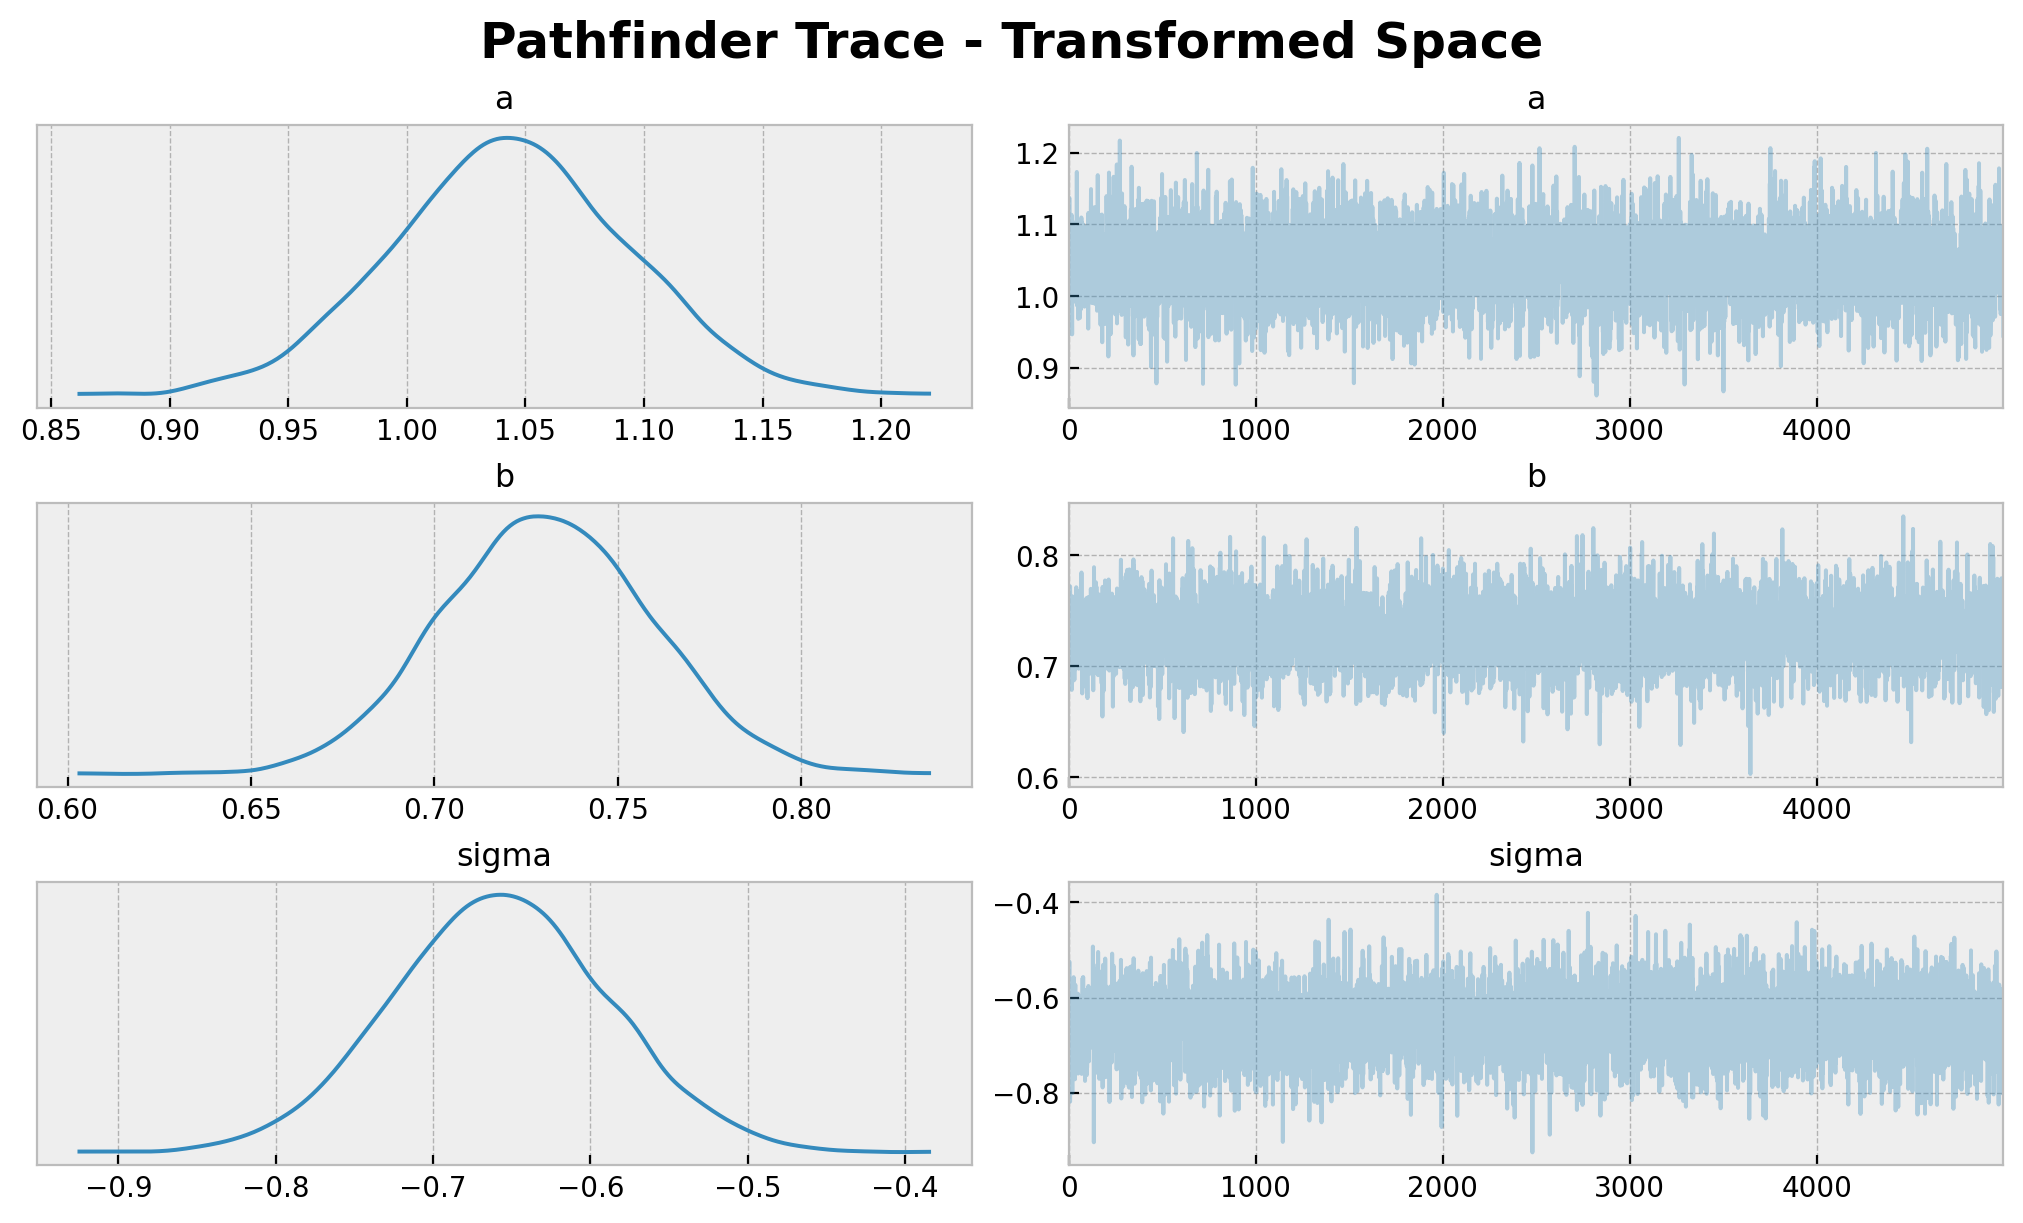

In [11]:
axes = az.plot_trace(
    data=idata_pathfinder,
    compact=True,
    figsize=(10, 6),
    backend_kwargs={"layout": "constrained"},
)
plt.gcf().suptitle(
    t="Pathfinder Trace - Transformed Space", fontsize=18, fontweight="bold"
);

Note that the value for `a` is close to the true value of `1.0`. However, the values for `b` and `sigma` do not match the true values of `2.0` and `0.5` respectively. Again, the reason is that we are working in the unconstrained space. We need to transform the samples to the original space to compare them with the true values.

### Transform Samples

We can use the `postprocess_fn` function returned by `initialize_model` to transform the samples from the unconstrained space to the constrained space:

In [12]:
# posterior samples
posterior_samples_pathfinder_transformed = jax.vmap(postprocess_fn(x, y))(
    posterior_samples_pathfinder
)

# posterior predictive samples
rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples_pathfinder_transformed = Predictive(
    model=model, posterior_samples=posterior_samples_pathfinder_transformed
)(rng_subkey, x)

Let's see the posterior distribution in the original space.

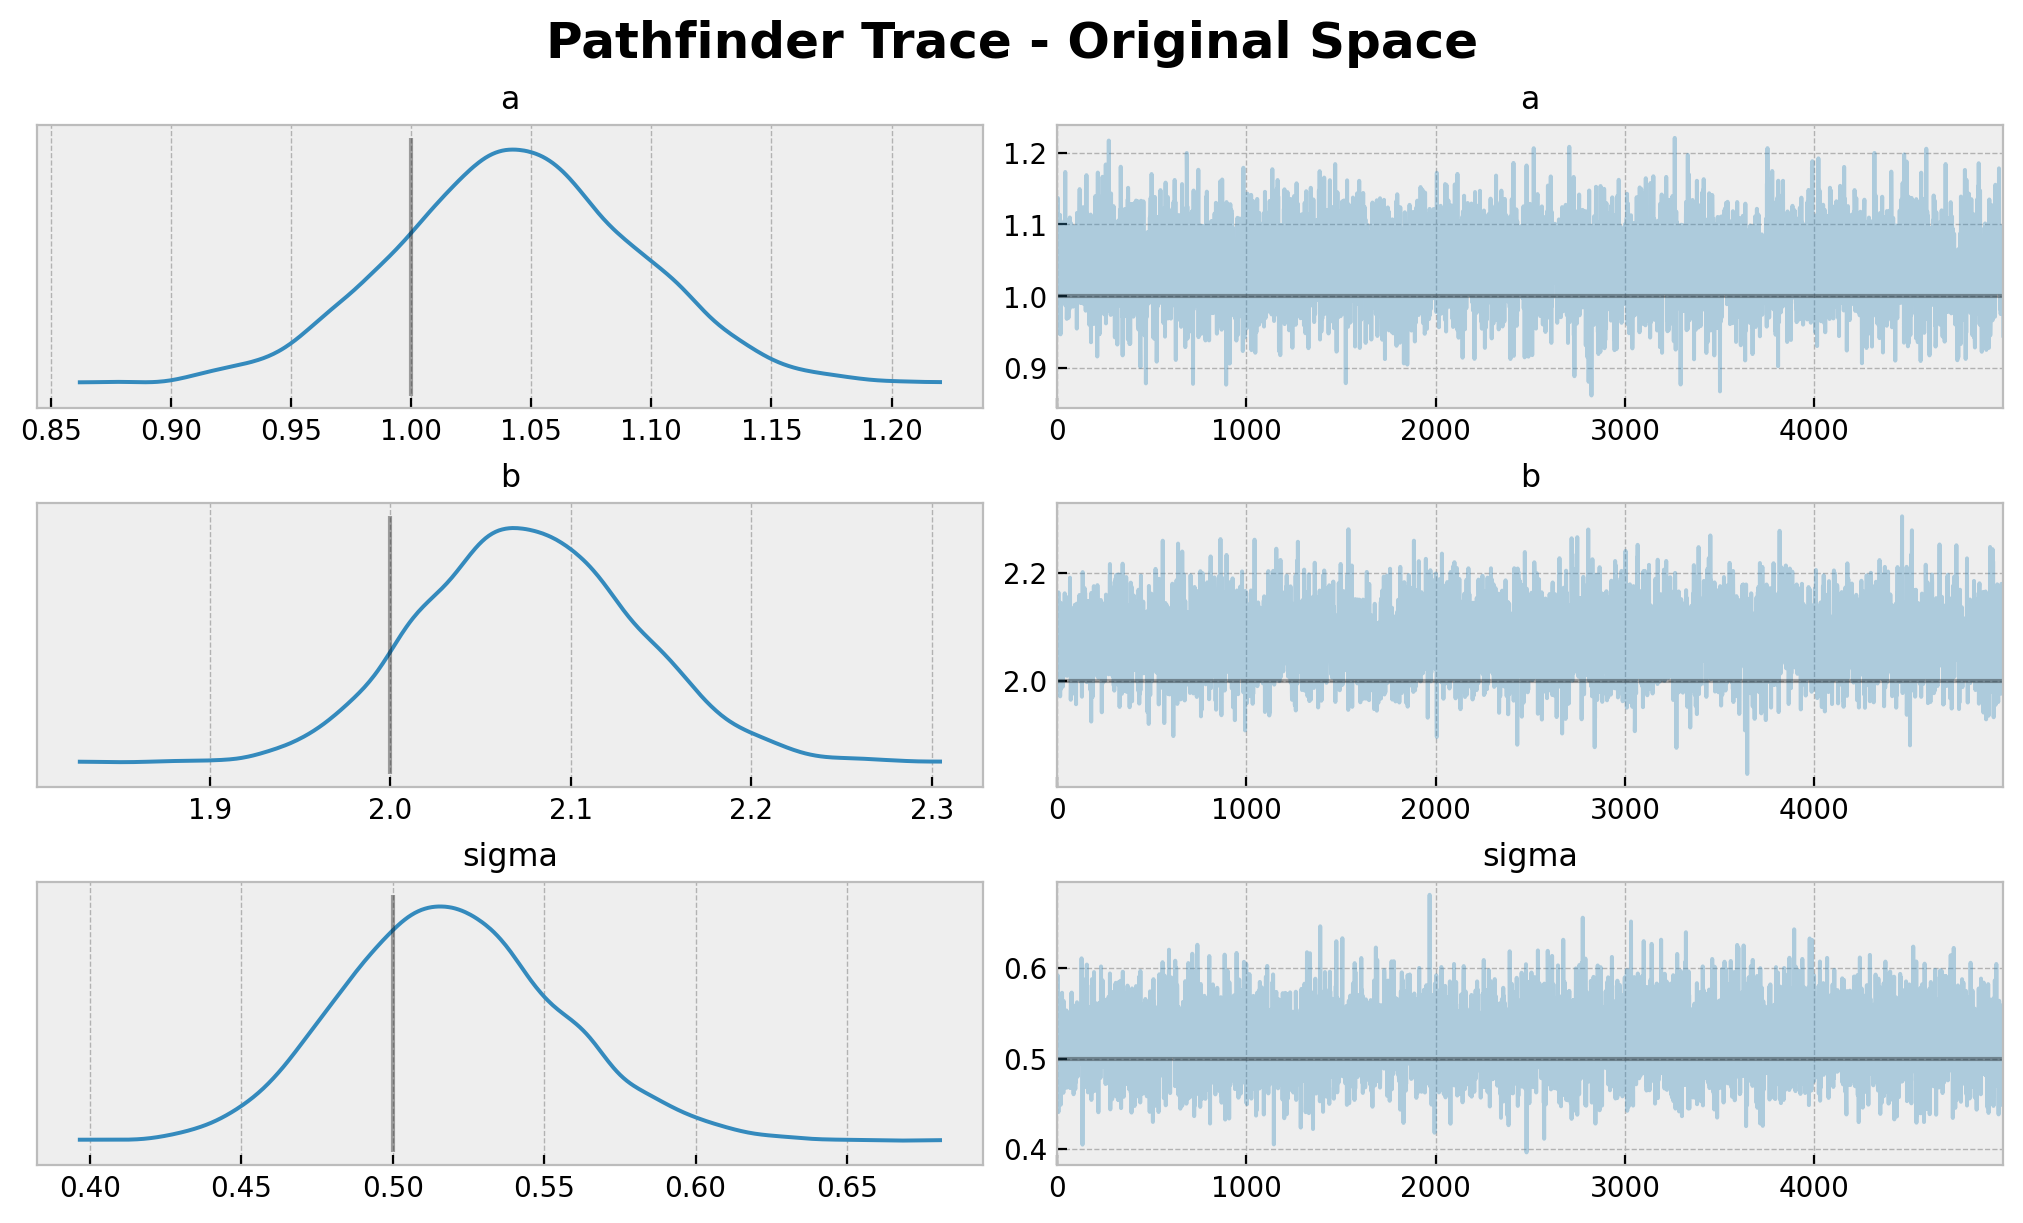

In [13]:
idata_pathfinder_transformed = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_samples_pathfinder_transformed.items()
    },
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_predictive_samples_pathfinder_transformed.items()
    },
)

axes = az.plot_trace(
    data=idata_pathfinder_transformed,
    var_names=["~mu"],
    compact=True,
    figsize=(10, 6),
    lines=[
        ("a", {}, a),
        ("b", {}, b),
        ("sigma", {}, sigma),
    ],
    backend_kwargs={"layout": "constrained"},
)
plt.gcf().suptitle(
    t="Pathfinder Trace - Original Space", fontsize=18, fontweight="bold"
);

Finally, we can visualize the posterior predictive distribution.

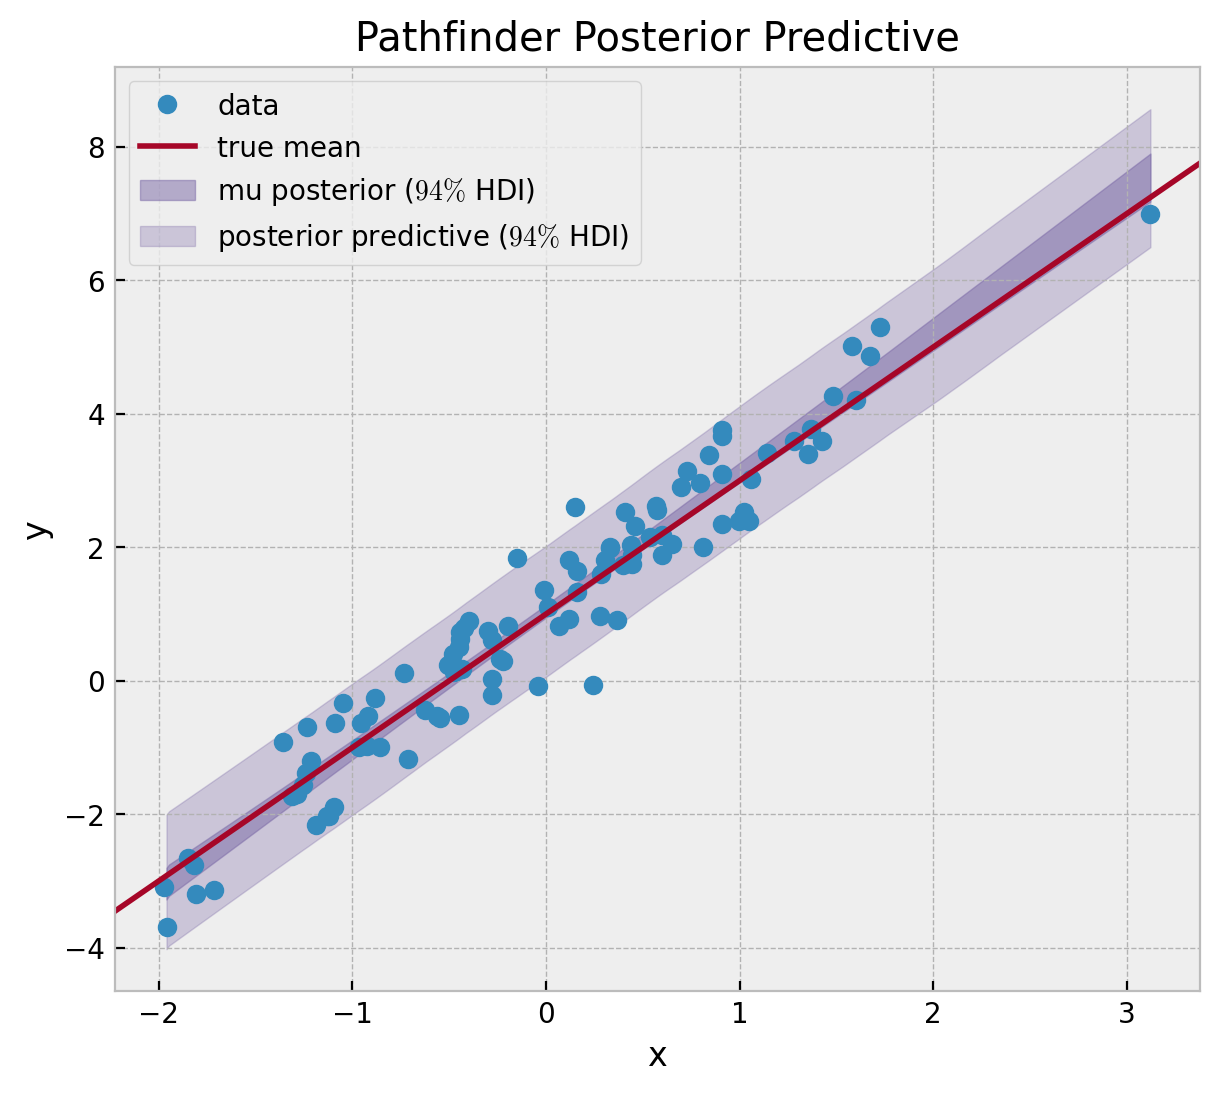

In [14]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(x, y, "o", c="C0", label="data")
ax.axline((0, a), slope=b, color="C1", label="true mean")
az.plot_hdi(
    x=x,
    y=idata_pathfinder_transformed["posterior_predictive"]["mu"],
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": "mu posterior ($94\\%$ HDI)"},
    ax=ax,
)
az.plot_hdi(
    x=x,
    y=idata_pathfinder_transformed["posterior_predictive"]["likelihood"],
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": "posterior predictive ($94\\%$ HDI)"},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(xlabel="x", ylabel="y", title="Pathfinder Posterior Predictive");

The results look good!

## FlowMC Normalizing Flow Sampler

We can run the FlowMC sampler in a similar way as above. We just need to adapt the log-density function to the FlowMC format.

### Define Log-Density Function

In [15]:
def logdensity_fn_flowmc(position, data):
    """FlowMC log-density function requires the position to be an array of shape
    (n_chains, n_dim) and the data to be a dictionary."""
    x = data["x"]
    y = data["y"]
    dict_position = dict(zip(param_info.z.keys(), position[..., None]))
    func = potential_fn(x, y)
    return -func(dict_position)

Let's verify that the log-density function is working.

In [16]:
n_dim = 3  # number of parameters
n_chains = 20  # number of chains

In [17]:
data = {"x": x, "y": y}
rng_key, subkey = random.split(rng_key)
initial_position_array = jax.random.normal(subkey, shape=(n_chains, n_dim))

In [18]:
logdensity_fn_flowmc(initial_position_array, data)

Array(-1179.1067, dtype=float32)

### Define FlowMC Sampler

We can now define the FlowMC sampler. For more details see [this example](https://github.com/kazewong/flowMC/blob/main/example/dualmoon.py) from the documentation.

In [19]:
# local sampler: Metropolis-adjusted Langevin algorithm sampler class builiding the mala_sampler method
mala_sampler = MALA(logpdf=logdensity_fn_flowmc, jit=True, step_size=0.1)

rng_key, subkey = random.split(rng_key)
# nortmalizing flow model: Rational quadratic spline normalizing flow model using distrax.
nf_model = MaskedCouplingRQSpline(
    n_features=n_dim, n_layers=4, hidden_size=[32, 32], num_bins=8, key=subkey
)

In [20]:
%%time

sampler_params = {
    "n_loop_training": 7,
    "n_loop_production": 7,
    "n_local_steps": 150,
    "n_global_steps": 100,
    "learning_rate": 0.001,
    "momentum": 0.9,
    "num_epochs": 30,
    "batch_size": 10_000,
    "use_global": True,
}


rng_key, rng_subkey = random.split(rng_key)
nf_sampler = Sampler(
    n_dim=n_dim,
    rng_key=rng_subkey,
    data=data,
    local_sampler=mala_sampler,
    nf_model=nf_model,
    **sampler_params,
)

nf_sampler.sample(initial_position_array, data)

rng_key, subkey = jax.random.split(rng_key)
nf_samples = nf_sampler.sample_flow(subkey, 4_000)

['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']


Global Tuning:   0%|          | 0/7 [00:00<?, ?it/s]

Compiling MALA body


Global Sampling: 100%|██████████| 7/7 [00:00<00:00, 13.19it/s]


CPU times: user 2min 34s, sys: 4min 32s, total: 7min 7s
Wall time: 43.3 s


### Visualize Results

We collect the posterior samples and visualize the results.

In [21]:
posterior_samples_flowmc = dict(zip(param_info.z.keys(), nf_samples.T))

flowmc_idata = az.from_dict(posterior=posterior_samples_flowmc)

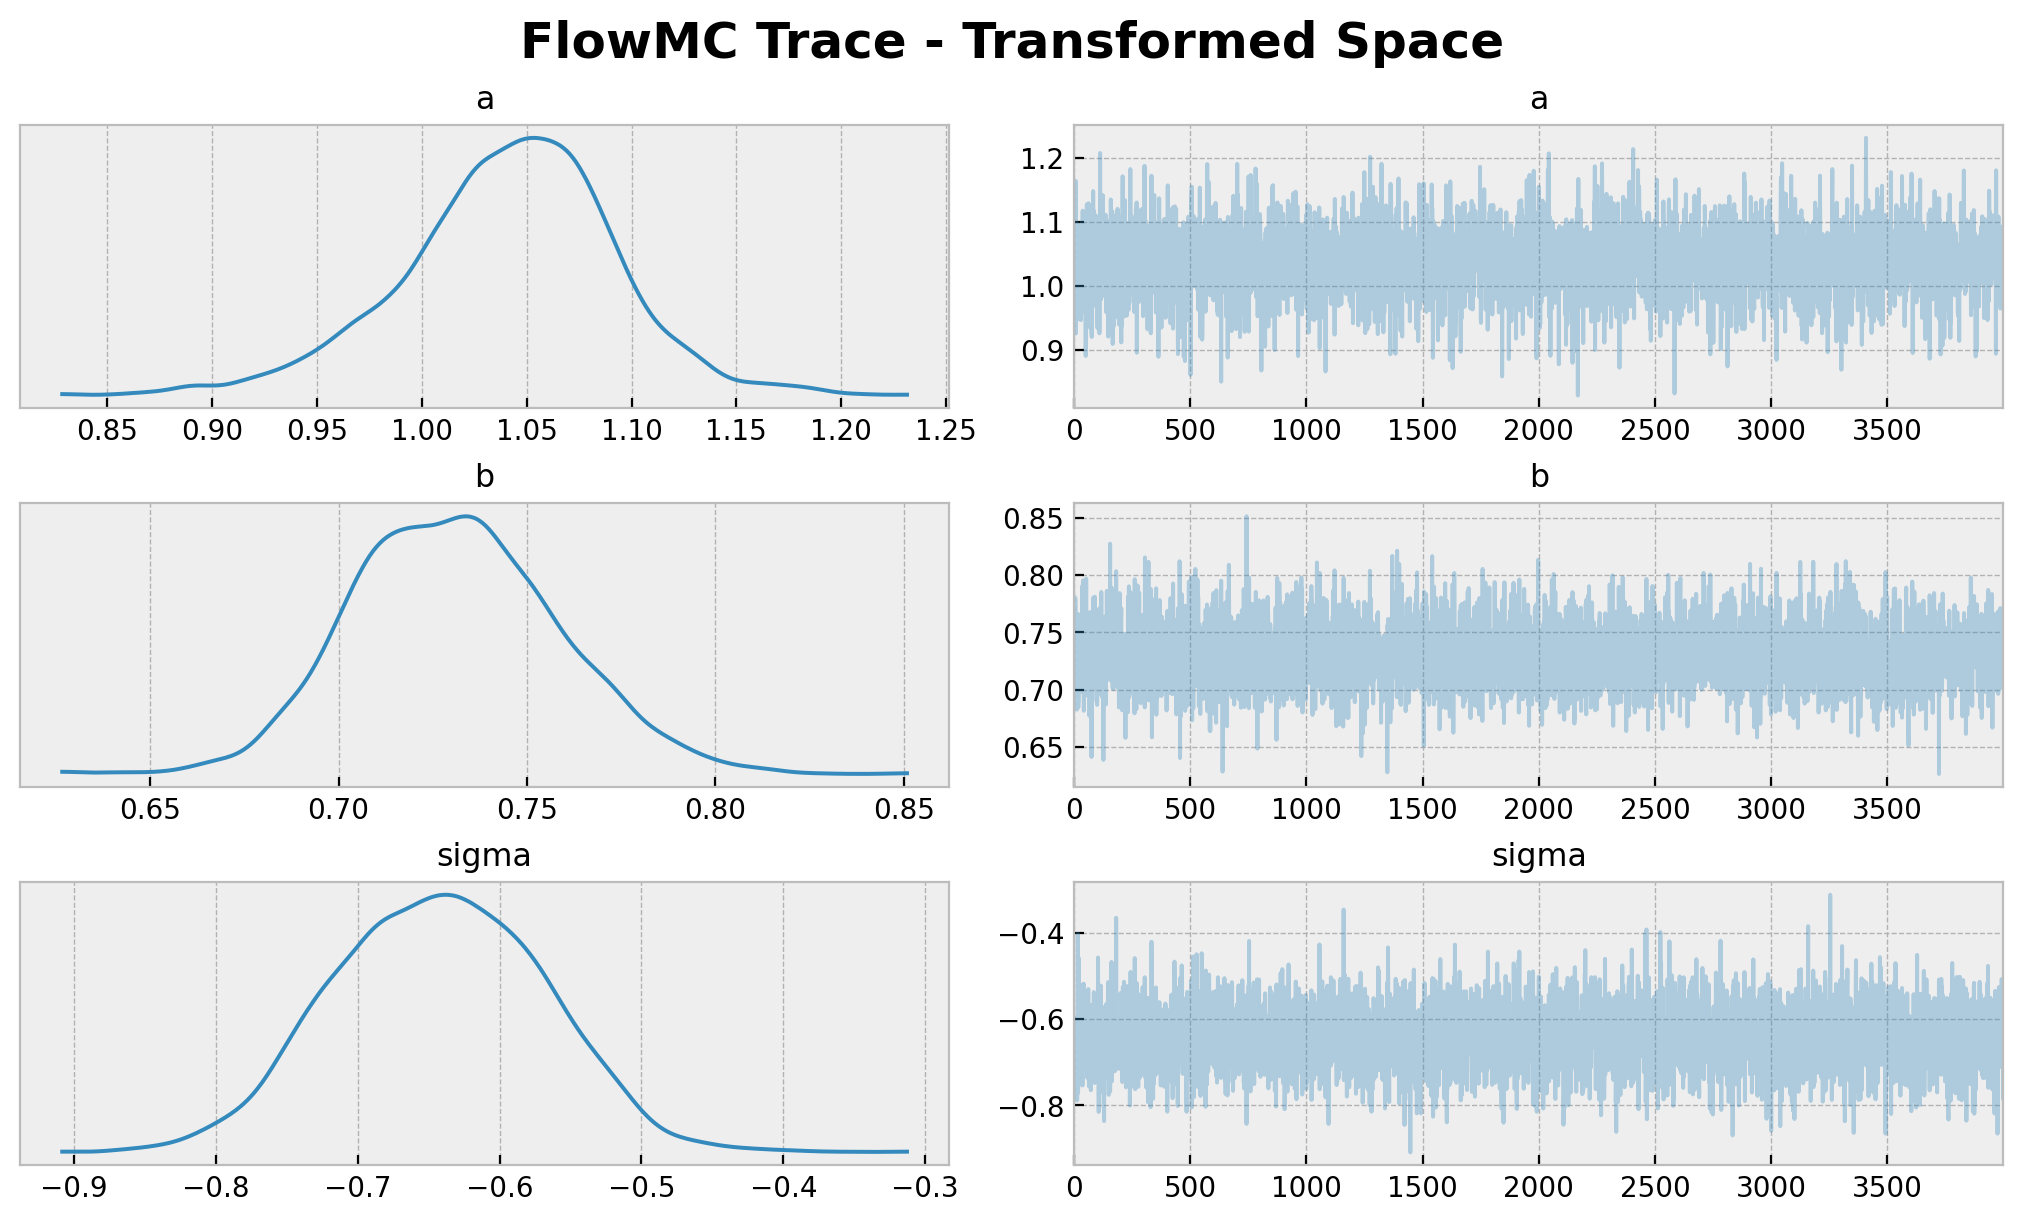

In [22]:
axes = az.plot_trace(
    data=flowmc_idata,
    compact=True,
    figsize=(10, 6),
    backend_kwargs={"layout": "constrained"},
)
plt.gcf().suptitle(
    t="FlowMC Trace - Transformed Space", fontsize=18, fontweight="bold"
);

### Transform Samples

We transform the samples to the original space as we did for Pathfinder.

In [23]:
# posterior samples
posterior_samples_flowmc_transformed = jax.vmap(postprocess_fn(x, y))(
    posterior_samples_flowmc
)

# posterior predictive samples
rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples_flowmc_transformed = Predictive(
    model=model, posterior_samples=posterior_samples_flowmc_transformed
)(rng_subkey, x)

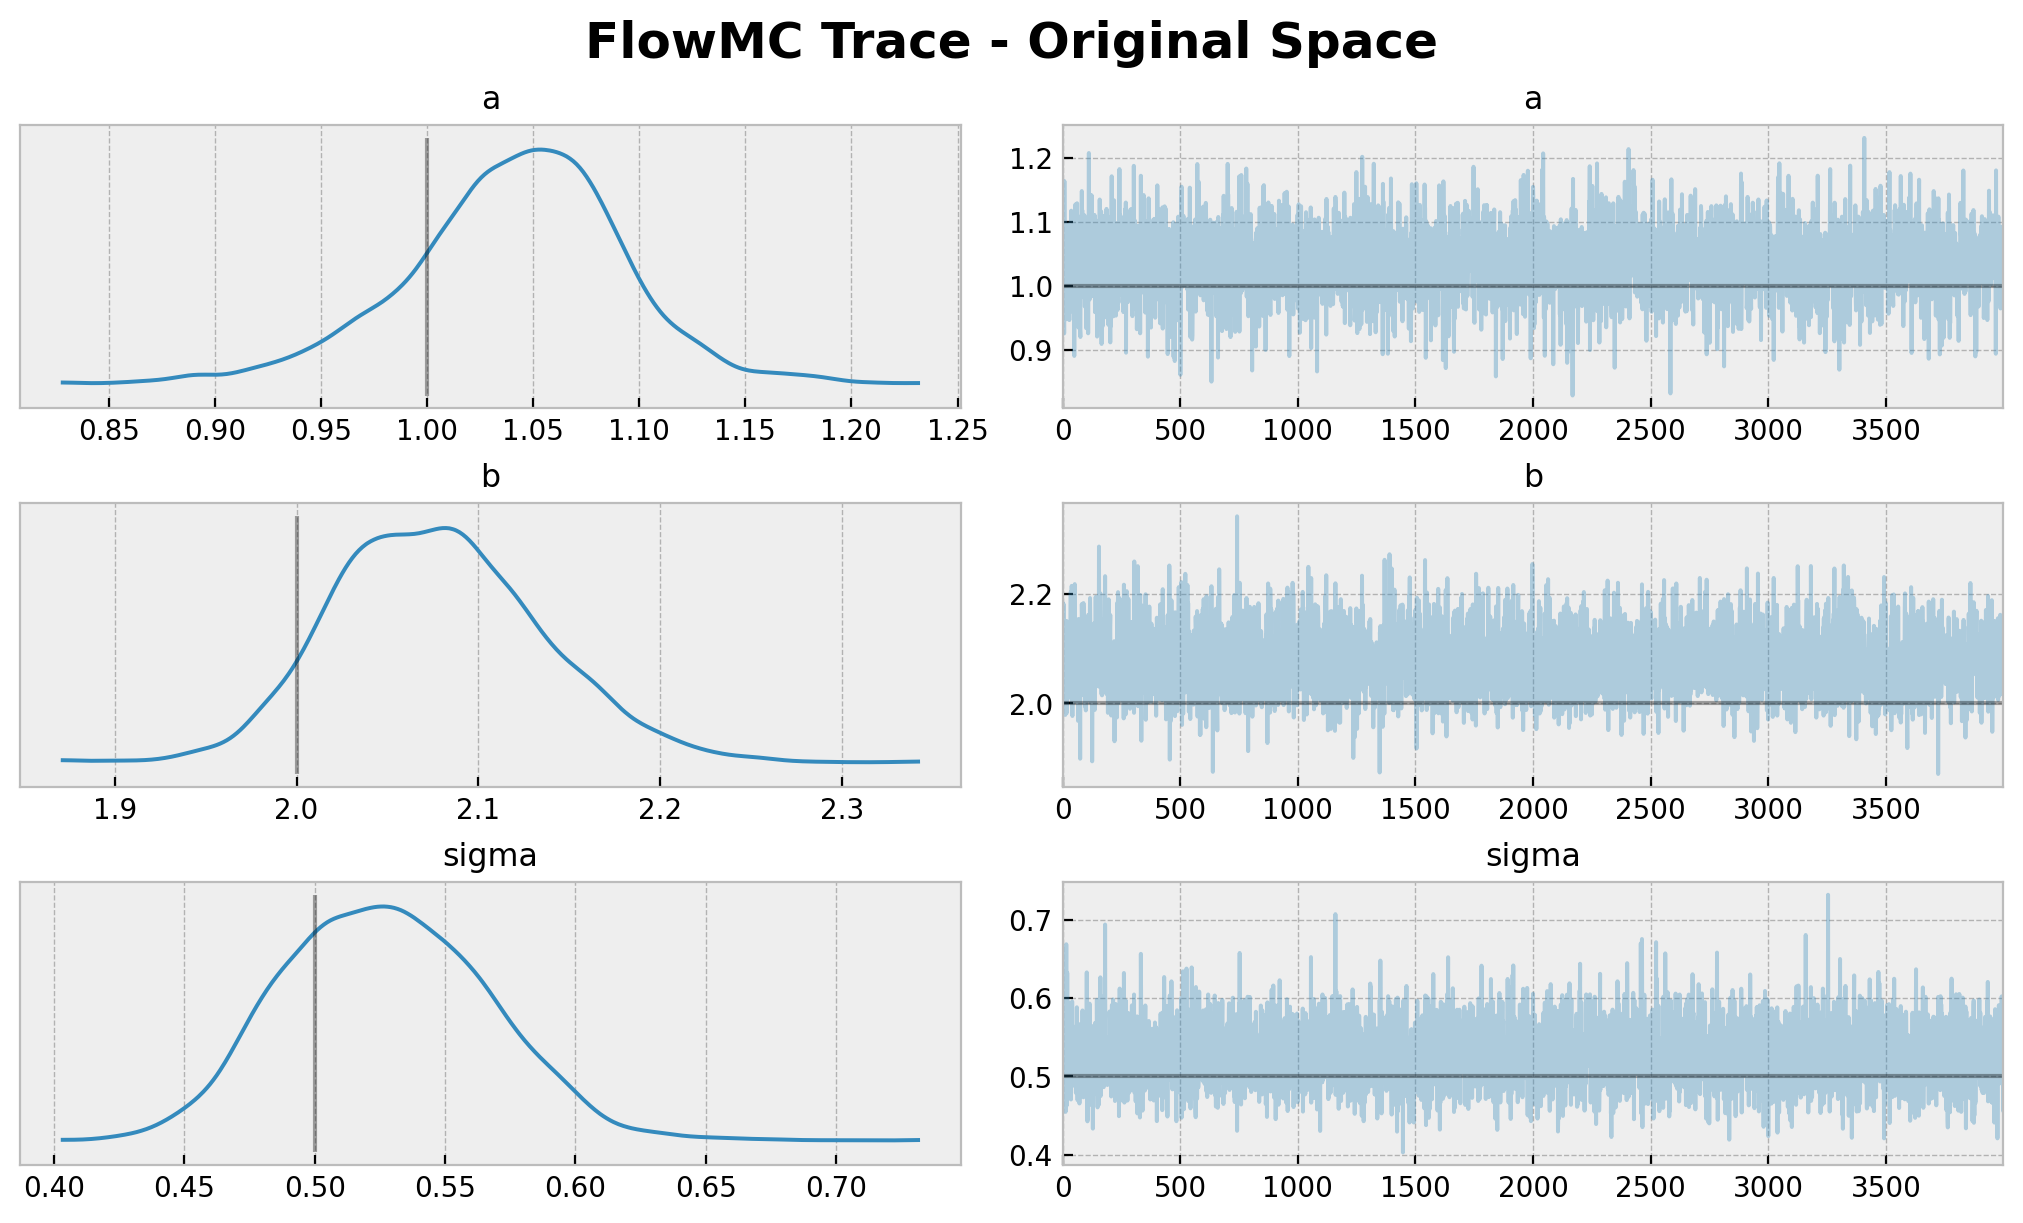

In [24]:
idata_flowmc_transformed = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_samples_flowmc_transformed.items()
    },
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_predictive_samples_flowmc_transformed.items()
    },
)

axes = az.plot_trace(
    data=idata_flowmc_transformed,
    var_names=["~mu"],
    compact=True,
    figsize=(10, 6),
    lines=[
        ("a", {}, a),
        ("b", {}, b),
        ("sigma", {}, sigma),
    ],
    backend_kwargs={"layout": "constrained"},
)
plt.gcf().suptitle(t="FlowMC Trace - Original Space", fontsize=18, fontweight="bold");

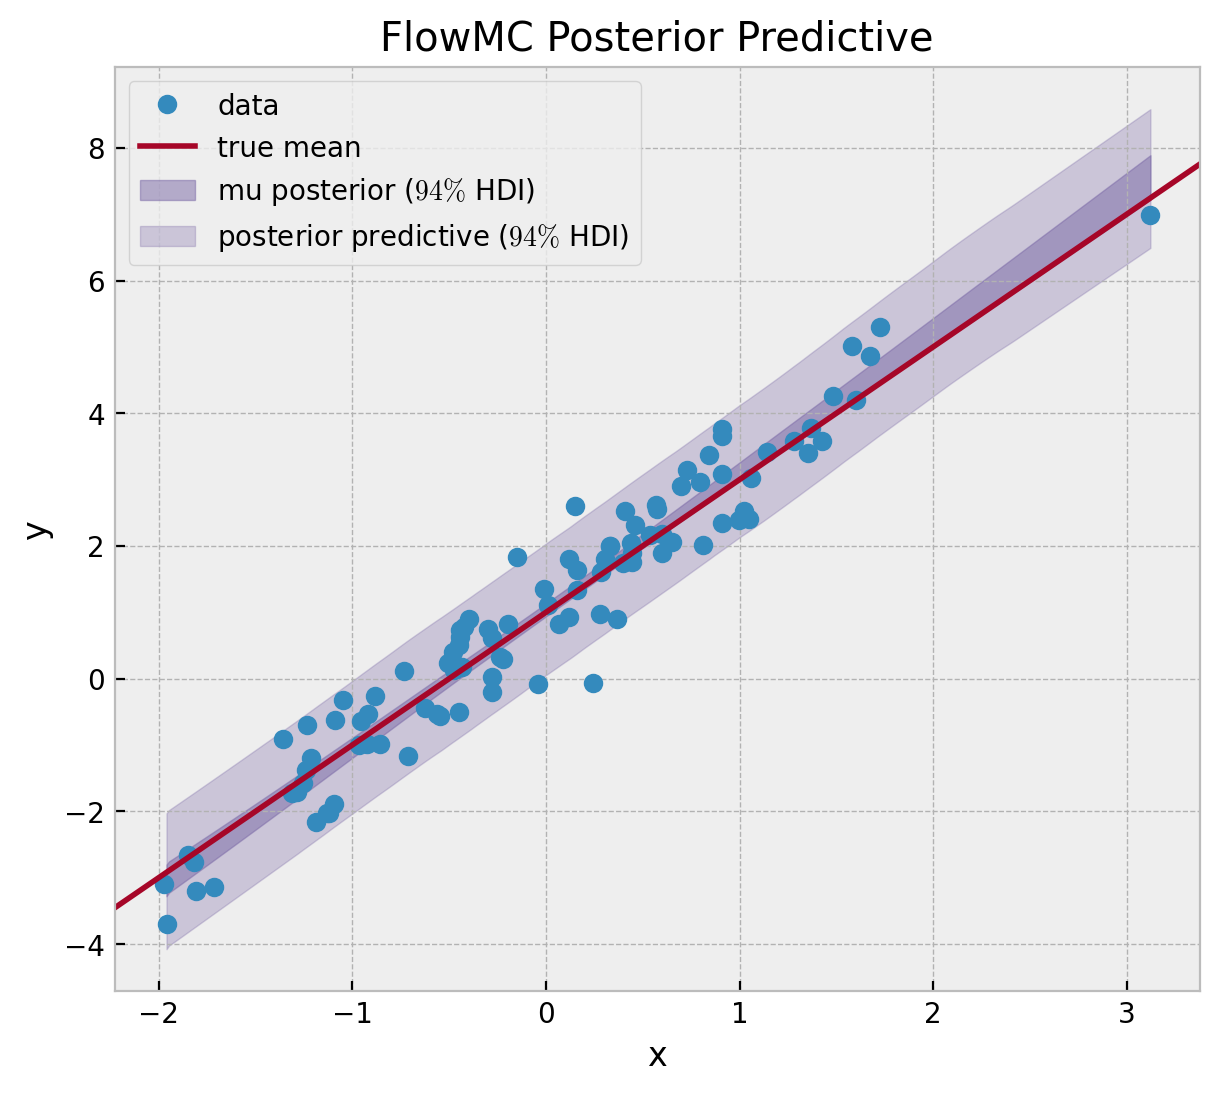

In [25]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(x, y, "o", c="C0", label="data")
ax.axline((0, a), slope=b, color="C1", label="true mean")
az.plot_hdi(
    x=x,
    y=idata_flowmc_transformed["posterior_predictive"]["mu"],
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": "mu posterior ($94\\%$ HDI)"},
    ax=ax,
)
az.plot_hdi(
    x=x,
    y=idata_flowmc_transformed["posterior_predictive"]["likelihood"],
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": "posterior predictive ($94\\%$ HDI)"},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(xlabel="x", ylabel="y", title="FlowMC Posterior Predictive");

## Model Comparison

Finally, we compare the results of the two samplers.

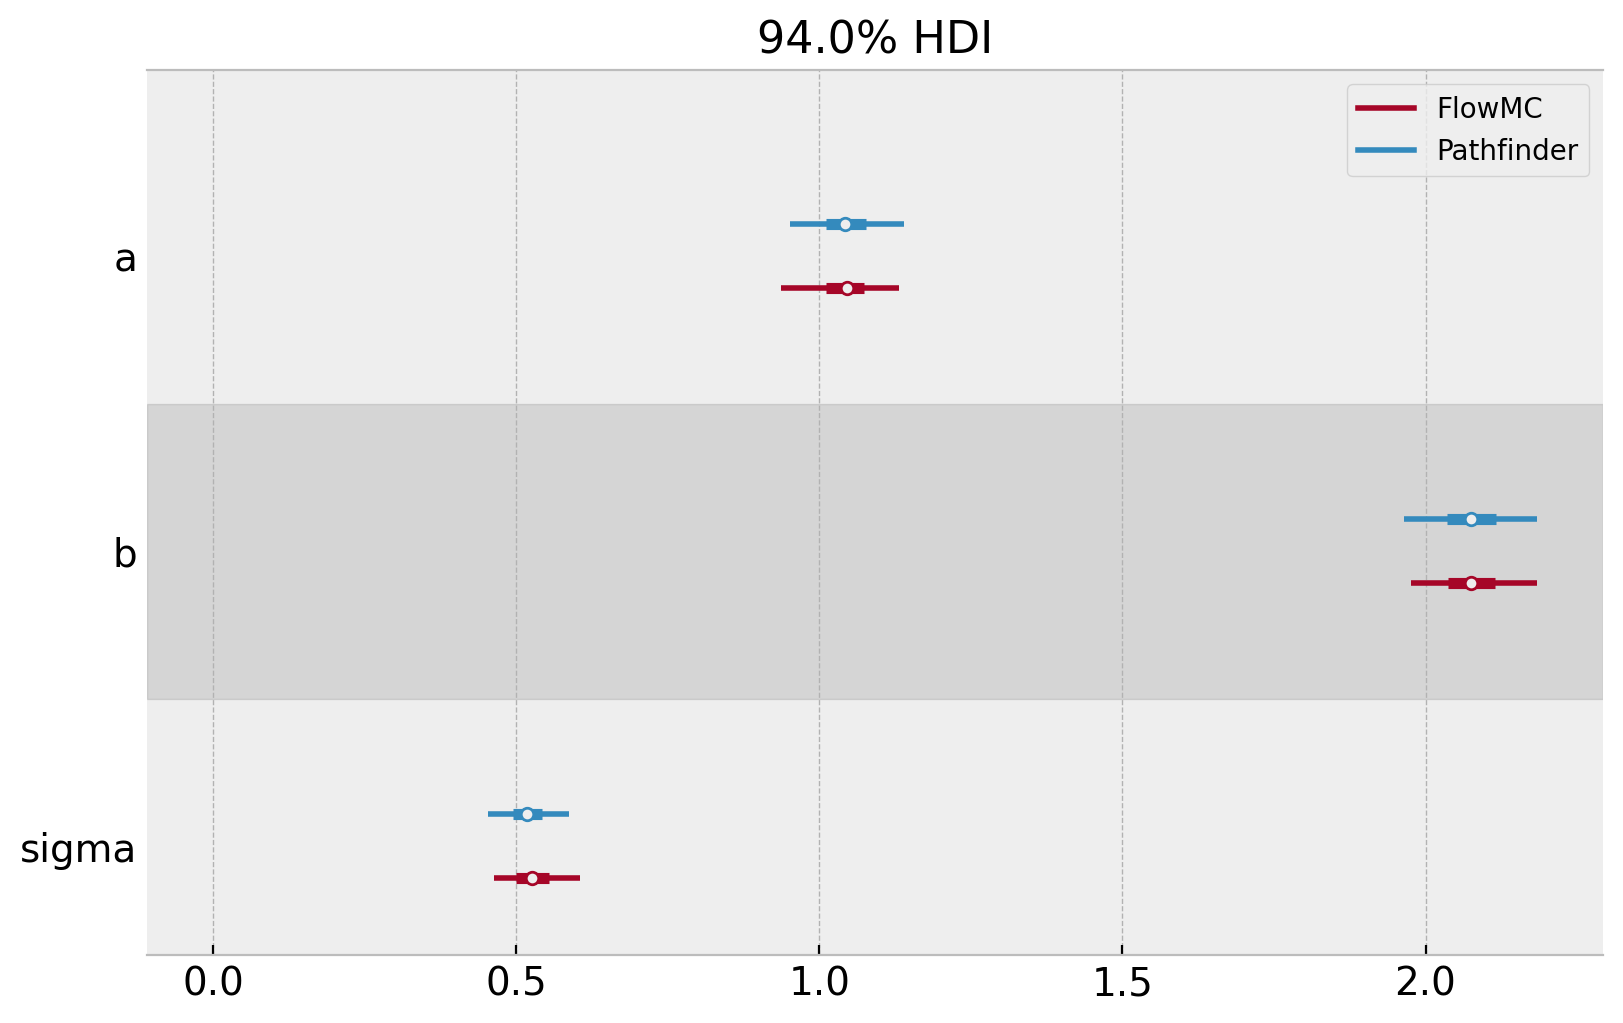

In [26]:
az.plot_forest(
    data=[idata_pathfinder_transformed, idata_flowmc_transformed],
    model_names=["Pathfinder", "FlowMC"],
    var_names=["a", "b", "sigma"],
    combined=True,
    figsize=(8, 5),
    backend_kwargs={"layout": "constrained"},
);

Both samplers perform well and the results are very similar.